`Course Instructor`: **John Chiasson**

`Author (TA)`: **Ruthvik Vaila**

## Notes
* This notebook has implementations of `Backprop`, `feedback alignment` (random backprop), `direct feedback alignment` and `feedforward` updates for a neural net with 1 hidden layer, `softmax` and `tanh/sigmoid` activations for output and hidden layers respectively  and `cross entropy` function. In this case we code backprop using the final update equations. You can see below that when the weights of the random fixed matrix are initialized using `tf.truncated_normal` then the performance is poor. (in this case see `fa` section). If `tf.random_uniform` with `golort` settings then the network performs better. See `dfa` section. HERE WE WILL USE tf.data API. And we will use spike features and we will also use spike count for error backprop. Here the shape of the inputs is `[None, n_input]` instead of `[n_ibput, None]`. We had to do this because nested elements in `from_tensor_slices` must have the same dimension in 0th rank [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). Everytime an iterator `iter = dataset.make_initializable_iterator()` gets initialized, the dataset is randomly shuffled so we need not shuffle again, [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). 
## References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
* Tested on `Python 3.7.5` with `Tensorflow 1.15.0` and `Keras 2.2.4`. 
* Tested on `Python 2.7.17` with `Tensorflow 1.15.3` and `Keras 2.2.4`.

In [1]:
import sys
sys.version

'3.7.5 (default, Nov  7 2019, 10:50:52) \n[GCC 8.3.0]'

In [10]:
import os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline
import h5py, pickle, IPython
from keras.utils.np_utils import to_categorical 
import numpy as np
import random, sys, time
%load_ext tensorboard

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
tf

1.15.0


<module 'tensorflow' from '/home/visionteam/python37_env/lib/python3.7/site-packages/tensorflow/__init__.py'>

## Hide code

In [5]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Plot settings

In [4]:
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25

## Load Data

In [5]:
num_classes = 47

filename = 'data/emnist_train_x.h5'
with h5py.File(filename, 'r') as hf:
    emnist_train_images = hf['pool1_spike_features'][:].astype(np.int8)
#emnist_train_images = theano.shared(emnist_train_images).dimshuffle(3,2,0,1).eval().reshape(1353588,-1)
print('Total train features:{}'.format(emnist_train_images.shape[0]))


filename = 'data/emnist_test_x.h5'
with h5py.File(filename, 'r') as hf:
    emnist_test_images = hf['pool1_spike_features'][:].astype(np.int8)
#emnist_test_images = theano.shared(emnist_test_images).dimshuffle(3,2,0,1).eval().reshape(225600,-1)
print('test features:{}'.format(emnist_test_images.shape[0]))


filehandle = open('data/emnist_train_y.pkl','rb')
emnist_train_labels = pickle.load(filehandle).astype(np.int).tolist()
filehandle.close()
emnist_train_labels = to_categorical(emnist_train_labels, num_classes=num_classes)


filehandle = open('data/emnist_test_y.pkl','rb')
emnist_test_labels = pickle.load(filehandle).astype(np.int)
filehandle.close()
emnist_test_labels = to_categorical(emnist_test_labels, num_classes=num_classes)
print('Length of test labels:{}'.format(emnist_test_labels.shape[0]))
n_images = len(emnist_train_images)


emnist_valid_images = emnist_train_images[0:int(0.09*n_images)]
print('Length of valid images:{}'.format(emnist_valid_images.shape[0]))
emnist_train_images = emnist_train_images[int(0.09*n_images):]
print('Length of train images:{}'.format(emnist_train_images.shape[0]))


emnist_valid_labels = emnist_train_labels[0:int(0.09*n_images)]
print('Length of valid labels:{}'.format(emnist_valid_labels.shape[0]))
emnist_train_labels = emnist_train_labels[int(0.09*n_images):]
print('Length of train labels:{}'.format(emnist_train_labels.shape[0]))
n_train = emnist_train_labels.shape[0]
n_test = emnist_test_labels.shape[0]
n_valid = emnist_valid_labels.shape[0]

all_train_images = emnist_train_images
all_train_labels = emnist_train_labels

Total train features:112799
test features:18800
Length of test labels:18800
Length of valid images:10151
Length of train images:102648
Length of valid labels:10151
Length of train labels:102648


batch_size = 5
epochs = 10
emnist_train_images = np.array_split(emnist_train_images, n_train/(batch_size))
emnist_train_labels = np.array_split(emnist_train_labels, n_train/(batch_size))
train_data = zip(emnist_train_images,emnist_train_labels)
print('Total number of epochs:{}'.format(epochs))
n_batches = len(train_data)
print('Number of batches in an epoch:{}'.format(n_batches))

## Open a session

In [6]:
sess= tf.InteractiveSession()
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

$tanh(x) = \frac{(e^{x} – e^{-x})}{(e^{x} + e^{-x})}$

$d\frac{tanh(x)}{dx} = 1 – (tanh(x))^{2}$

$\sigma(x) = \frac{1.0}{1 + e^{-x}}$

$d\frac{\sigma(x)}{dx} = \sigma(x)*(1 - \sigma(x))$

## Setup a graph

In [7]:
n_input = 3630
n_middle = 1200
n_out = num_classes
batch_size = tf.placeholder(tf.int64, name='batch_size') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()
eta = tf.placeholder(tf.float32)
drop_out = tf.placeholder(tf.float32)
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(2.0/(n_input))
    
    #w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    tf.summary.histogram('w_2', w_2)
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    tf.summary.histogram('b_2', b_2)
with tf.name_scope('op_lyr_w_b'):
    
    low = -tf.math.sqrt(2.0/(n_middle))
    high = tf.math.sqrt(2.0/(n_middle))
    #w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,10],minval=low,maxval=high), name = 'W_3')
    w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    tf.summary.histogram('w_3', w_3)
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    #locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]),n_middle*batch_size )
    #locs_to_drop = tf.reshape(locs_to_drop, z_2.shape)
    #locs_to_drop = tf.reshape(locs_to_drop, [n_middle,batch_size])
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    a_2 = spkNeuron(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    tf.summary.histogram('z_3', z_3)
    a_3  = spkNeuron(z_3) ##UNCOMMENT THIS LINE AND COMMENT ABOVE LINE IF YOU WANT spike SQUISHING
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    #a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum(tf.multiply(a_3,tf.log(y)),axis=0), name = 'cost_calc') GIVES inf COST!!!
#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),name = 'cost_calc')#WORKS
    ##COMMENT BELOW LINES IF YOU WANT SOFTMAX
    dc_da = -tf.subtract(labels,a_3, name = 'y_minus_a_3')
    cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = d_z_3
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.matmul(tf.transpose(a_2),d_z_3, name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    #d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), spkNeuron(z_2), name = 'delta2')
    d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = d_z_2
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.matmul(tf.transpose(features),d_z_2, name = 'delta_w2')
    tf.summary.histogram('d_w_2', d_w_2)

step = [
    tf.assign(w_2,
            tf.subtract(w_2, tf.multiply(eta/tf.cast(batch_size, tf.float32), d_w_2)))
  , tf.assign(b_2,
            tf.subtract(b_2, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_2, axis=[0]),axis=0))))
  , tf.assign(w_3,
            tf.subtract(w_3, tf.multiply(eta/tf.cast(batch_size, tf.float32), d_w_3)))
  , tf.assign(b_3,
            tf.subtract(b_3, tf.multiply(eta,
                               tf.expand_dims(tf.reduce_mean(d_b_3, axis=[0]),axis=0))))
]

with tf.name_scope('acc_calc'):
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)


init_op = tf.global_variables_initializer()

## Write the summary to disk

In [8]:
path = '/home/visionteam/tf_tutorials/logs'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/bb_tfdata_nn_train', sess.graph)

## Load Tensorboard

### Exercise
* Click on the `DISTRIBUTIONS` and `HISTOGRAMS` to visualize the gradients and activations. Check for gradient explosion or vanishing gradients. Also check for internal covariate shift and take necessary measures.

In [11]:
%tensorboard --logdir {path}

Reusing TensorBoard on port 6009 (pid 10468), started 0:21:18 ago. (Use '!kill 10468' to kill it.)

### Exercise
* Re-write the below cell to perform the experiment `iteration` number of times as in `bare_bones_tf_nn.ipynb` file.

* You'll notice that there is a memory leak in GPU and it's because of the line in the below cell

`best_step = [tf.assign(w_2,best_params[0][0]), tf.assign(b_2,best_params[0][1]),tf.assign(w_3,best_params[1][0]), tf.assign(b_3,best_params[1][1])]` 

* The above line was used to fix the weights of the network with the best validation weights to test on it.

* Tensorflow sees that line as we are adding a new variable to tensorflow graph everytime we execute it. Instead we need to define an update operation in the above cell for each of the variables (biases and weights) and use that to update the weights and biases. Something like:
    
`w_2_update_placeholder = tf.placeholder(w_2.dtype, shape=w_2.get_shape(),name='update_w2') 
 w_2_update_op = w_2.assign(w_2_update_placeholder)` 
      
* And then use `sess.run(w_2_update_op, {w_2_update_placeholder:best_params[0][0]})` to re-wire the network. 

* For more info [see](https://github.com/tensorflow/tensorflow/issues/4151)


In [13]:
train_accuracies = []
train_costs = []
val_accuracies = []
val_costs = []
best_val = 0
epochs = 2
best_params = None
BATCH_SIZE = 5
logging_count = 0
n_batches = int(len(all_train_images)/BATCH_SIZE)
t1 = time.time()
sess.run(init_op,options=run_options, run_metadata=run_metadata)
for i in range(epochs):
    
    sess.run(iter.initializer, feed_dict={ a_1: all_train_images, y: all_train_labels,
                                          batch_size: len(all_train_images)})
    print('Epoch:{}'.format((i)))
    
    ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
    ## train cost
    #summary, train_cost = sess.run([merged,cost], feed_dict = {a_1 : all_train_images.transpose(),
    #                                            y : all_train_labels.transpose()})
    #train_writer.add_summary(summary,i)  OOM ERROR
    #train_cost, train_accuracy = sess.run([cost,acct_res] ,feed_dict = {drop_out : 0.0 ,a_1: all_train_images, 
    #                                      y: all_train_labels,batch_size: len(all_train_images)})
    train_cost, train_accuracy = sess.run([cost,acct_res] ,feed_dict = {drop_out : 0.0})
    train_costs.append(train_cost)
    train_accuracies.append(train_accuracy)
    
    
    print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

    ### CALCULATE VALID COSTS AND VALID ACCURACIES
    sess.run(iter.initializer, feed_dict={ a_1: emnist_valid_images, y: emnist_valid_labels,
                                          batch_size: len(emnist_valid_images)})
    ## valid cost
    #summary, val_cost, val_acc = sess.run([merged,cost,acct_res], feed_dict = {drop_out : 0.0, a_1: emnist_valid_images, 
    #                                            y: emnist_valid_labels,batch_size: len(emnist_valid_images)} )
    summary, val_cost, val_acc = sess.run([merged,cost,acct_res], feed_dict = {drop_out : 0.0})
    val_costs.append(val_cost)
    val_accuracies.append(val_acc)
    
    if(val_acc>best_val):
        best_val = val_acc
        best_params = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
    
    print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
    
    sess.run(iter.initializer, feed_dict={a_1: all_train_images, y: all_train_labels,
                                          batch_size: BATCH_SIZE})
    #START TRAINING
    for j in range(n_batches):
        if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
            if(((j)% 1000 ==0)):
                logging_count+=1
                summary,_ = sess.run([merged,step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,eta:0.001})
                train_writer.add_summary(summary, logging_count)
            else:
                sess.run([step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,eta:0.001})
        else:
            print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
        
sess.run(iter.initializer, feed_dict={ a_1: emnist_test_images, y: emnist_test_labels,
                                          batch_size: len(emnist_test_images)})
test_acc = sess.run(acct_res, feed_dict = {drop_out:0.0})

print('Final test accuracy is:{}'.format(test_acc))

best_step = [tf.assign(w_2,best_params[0][0]), tf.assign(b_2,best_params[0][1]),tf.assign(w_3,best_params[1][0]),\
    tf.assign(b_3,best_params[1][1])]

sess.run(best_step)
sess.run(iter.initializer, feed_dict={ a_1: emnist_test_images, y: emnist_test_labels,
                                          batch_size: len(emnist_test_images)})
test_acc = sess.run(acct_res, feed_dict = {drop_out:0.0})

print('Test accuracy corresp to best val acc:{}'.format(test_acc))
print('Time taken:{}'.format(time.time()-t1))
train_writer.close()


Epoch:0
training cost:12.119047164916992 and training accuracy:0.0227378997951746
validation cost:12.109890937805176 and validation accuracy:0.022559354081749916
Epoch:1
training cost:0.25698989629745483 and training accuracy:0.6806854605674744
validation cost:0.2977539300918579 and validation accuracy:0.6379666924476624
Final test accuracy is:0.6542553305625916
Test accuracy corresp to best val acc:0.6298936009407043
Time taken:371.31771183013916


## Plots

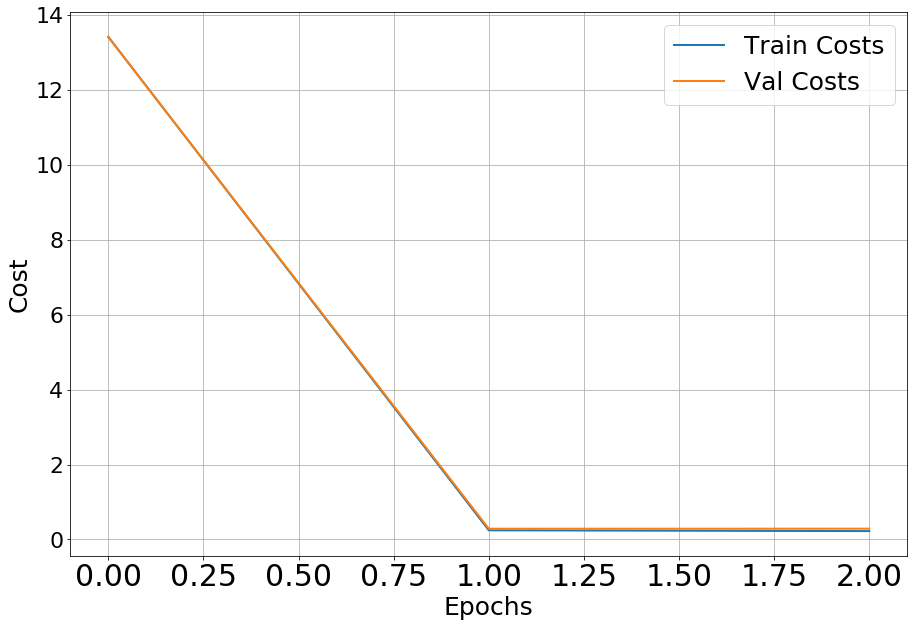

In [10]:
plt.plot(train_costs, label="Train Costs")
plt.plot(val_costs, label="Val Costs")
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.show()

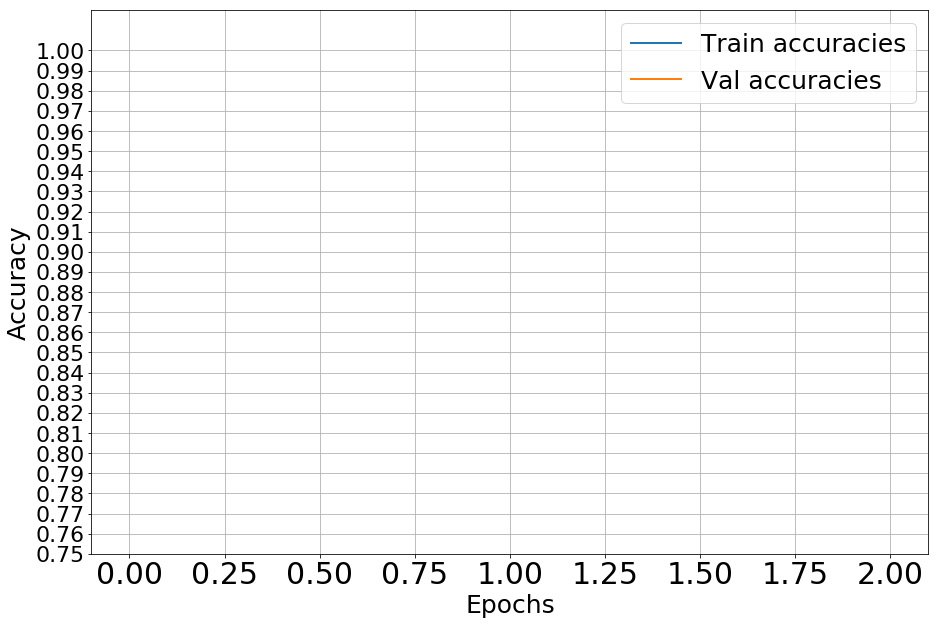

In [11]:
plt.plot(train_accuracies, label="Train accuracies")
plt.plot(val_accuracies, label="Val accuracies")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.yticks([0.01*i for i in range(1,101)])
plt.ylim(0.75,1.02)
plt.grid()
plt.legend()
plt.show()

## Restart the network to free up the `GPU` and `RAM`

In [12]:
IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

NameError: name 'IPython' is not defined

### Exercise
* Read more about [chrome-tracing](https://towardsdatascience.com/howto-profile-tensorflow-1a49fb18073d) and implement it.
* Do a hyper parameter study for learning rate ($\eta$) and dropout. Generate 3 randomly generated values for both the hyper parameters between reasonable limits and take all the combinations and train 9 networks. Train each of the combination 5 times, make sure the initialized weights for all the 5 repetitions are different. Also, make sure that the same set of initialized weights are used across 9 combinations of hyperparameters. 

`Fix the numpy random seed
Generate 5 different sets of random biases and weights numpy arrays.
all_metrics = []
for hyper_param in hyper_param_combo_set:
    a_hyper_param_metrics = []
    for a_set_of_weights in 5_sets_of_weights:
         train_an_NN
         a_hyper_param_metrics.append(metrics)
    all_metrics.append(a_hyper_param_metrics)`

In [ ]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/'
writer = tf.summary.FileWriter(path, sess.graph)
writer.flush()
tl = timeline.Timeline(run_metadata.step_stats)
ctf = tl.generate_chrome_trace_format()
with open(path+'/timeline.json', 'w') as f:
    f.write(ctf)


writer.add_run_metadata(run_metadata, 'mysess')
writer.flush()
writer.close()